In [2]:
#!pip install split-folders --upgrade --quiet

In [19]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from tensorflow import keras
from keras.models import load_model,Sequential
from keras.preprocessing.image import ImageDataGenerator as Imgen
from keras.preprocessing import image
from keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Dropout
from keras.metrics import Precision, Recall

from PIL import Image
from sklearn.metrics import classification_report,confusion_matrix

import os

In [2]:
import splitfolders
splitfolders.ratio("rice_leaf_diseases",output="splitted rice",ratio=(0.8,0.2,0)) #tr-val-test

Copying files: 120 files [00:00, 121.11 files/s]


In [18]:
data='splitted rice'
print(os.listdir(data))

['test', 'train', 'val']


In [19]:
count = ['splitted rice/train', 'splitted rice/val']
for file in count:
    origin_subfolders=[f'{file}/{folder}' for folder in os.listdir(file)]
    for sub_dir in origin_subfolders:
        print(sub_dir,':', len(os.listdir(sub_dir)))
    print('\n')

splitted rice/train/Bacterial leaf blight : 32
splitted rice/train/Brown spot : 32
splitted rice/train/Leaf smut : 32


splitted rice/val/Bacterial leaf blight : 8
splitted rice/val/Brown spot : 8
splitted rice/val/Leaf smut : 8




In [2]:
#image data from the forlder using image data generator

train_gen = Imgen(preprocessing_function=keras.applications.densenet.preprocess_input,
                 zoom_range=0.2,
                  shear_range=0.2,
                  vertical_flip=True,
                  width_shift_range=0.2,
                  height_shift_range=0.2,
                  fill_mode='nearest'
                 )

val_gen = Imgen(preprocessing_function=keras.applications.densenet.preprocess_input
                 )

In [3]:
train_ds = train_gen.flow_from_directory("splitted rice/train",
                                       target_size=(224,224),
                                        seed = 123,
                                        batch_size=6    #berapa data yang disebarkan ke NN
                                       )

val_ds = val_gen.flow_from_directory("splitted rice/val",
                                       target_size=(224,224),
                                        seed = 123,
                                        batch_size=6
                                       ) #shuffle=False

Found 96 images belonging to 3 classes.
Found 24 images belonging to 3 classes.


In [4]:
#get the name of classess for ease of use

classes = list(train_ds.class_indices.keys())
classes

['Bacterial leaf blight', 'Brown spot', 'Leaf smut']

In [23]:
#extracting one batch from datagen for visualisation purposes

X,Y = next(train_ds)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


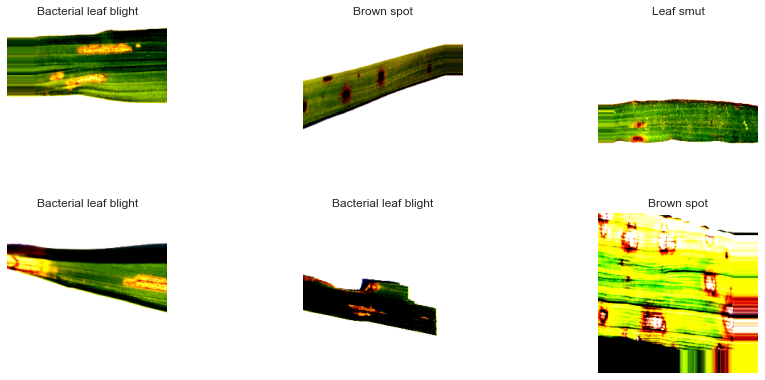

In [24]:
def plot_images(img,labels):
    plt.figure(figsize=(15,10))
    for i in range(6):
        plt.subplot(3,3,i+1)
        plt.imshow(img[i])
        plt.title(classes[np.argmax(labels[i])])
        plt.axis('off')

plot_images(X,Y)

In [5]:
#Using Transfer Learning to build the Model

from keras.applications.densenet import DenseNet201

base_model = DenseNet201(include_top=False,
                  input_shape=(224,224,3),
                   weights = 'imagenet',
                    pooling='avg'
                  )
base_model.trainable = False

In [6]:
inputs = base_model.input
l1 = Dense(128,activation='relu')(base_model.output)
outputs = Dense(3,activation='softmax')(l1)         #logits size=[6,3]
model = keras.Model(inputs=inputs,outputs=outputs)

In [25]:
#compile 
model.compile(optimizer='adam',loss='categorical_crossentropy',
              metrics=['acc',
                       Precision(class_id=0, name='precision_0'),
                       Precision(class_id=1, name='precision_1'),
                       Precision(class_id=2, name='precision_2'),
                       Recall(class_id=0, name='recall_0'),
                       Recall(class_id=1, name='recall_1'),
                       Recall(class_id=2, name='recall_2'),
                      ])
#'accuracy', 'recall',

In [26]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

conv5_block1_0_bn (BatchNormali (None, 7, 7, 896)    3584        pool4_pool[0][0]                 
__________________________________________________________________________________________________
conv5_block1_0_relu (Activation (None, 7, 7, 896)    0           conv5_block1_0_bn[0][0]          
__________________________________________________________________________________________________
conv5_block1_1_conv (Conv2D)    (None, 7, 7, 128)    114688      conv5_block1_0_relu[0][0]        
__________________________________________________________________________________________________
conv5_block1_1_bn (BatchNormali (None, 7, 7, 128)    512         conv5_block1_1_conv[0][0]        
__________________________________________________________________________________________________
conv5_block1_1_relu (Activation (None, 7, 7, 128)    0           conv5_block1_1_bn[0][0]          
__________________________________________________________________________________________________
conv5_bloc

In [27]:
#Defining callbacks to get the best model possible

my_calls = [keras.callbacks.EarlyStopping(monitor='val_loss',patience=5),
            keras.callbacks.ModelCheckpoint("Model.h5",verbose=1,save_best_only=True)]

In [28]:
#Training

hist = model.fit(train_ds,epochs=30,validation_data=val_ds,callbacks=my_calls)

Epoch 1/30
16/16 [==============================] - 61s 3s/step - loss: 0.3290 - acc: 0.8909 - precision_0: 0.9855 - precision_1: 0.8847 - precision_2: 0.8339 - recall_0: 0.9945 - recall_1: 0.8014 - recall_2: 0.8674 - val_loss: 0.5112 - val_acc: 0.8750 - val_precision_0: 1.0000 - val_precision_1: 0.8571 - val_precision_2: 0.7778 - val_recall_0: 1.0000 - val_recall_1: 0.7500 - val_recall_2: 0.8750

Epoch 00001: val_loss improved from inf to 0.51123, saving model to Model.h5
Epoch 2/30
16/16 [==============================] - 33s 2s/step - loss: 0.1223 - acc: 0.9482 - precision_0: 1.0000 - precision_1: 0.8616 - precision_2: 0.9886 - recall_0: 0.9922 - recall_1: 0.9900 - recall_2: 0.8475 - val_loss: 0.3631 - val_acc: 0.9167 - val_precision_0: 1.0000 - val_precision_1: 0.8750 - val_precision_2: 0.8750 - val_recall_0: 1.0000 - val_recall_1: 0.8750 - val_recall_2: 0.8750

Epoch 00002: val_loss improved from 0.51123 to 0.36310, saving model to Model.h5
Epoch 3/30
16/16 [======================

In [29]:
#Getting the saved model

model = load_model("./Model.h5")

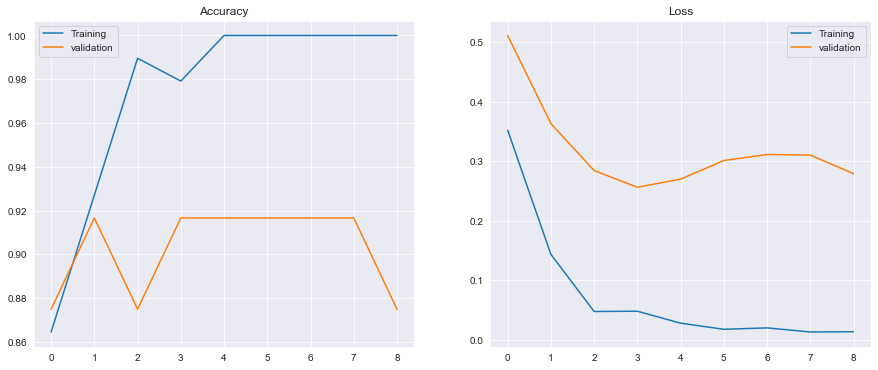

In [32]:
#Graphs to show loss and accuracy along the training

plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
plt.plot(hist.epoch,hist.history['acc'],label = 'Training')
plt.plot(hist.epoch,hist.history['val_acc'],label = 'validation')

plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(hist.epoch,hist.history['loss'],label = 'Training')
plt.plot(hist.epoch,hist.history['val_loss'],label = 'validation')

plt.title("Loss")
plt.legend()
plt.show()

In [33]:
#test
model.evaluate(val_ds)

4/4 [==============================] - 13s 2s/step - loss: 0.2562 - acc: 0.9167 - precision_0: 1.0000 - precision_1: 0.8750 - precision_2: 0.8750 - recall_0: 1.0000 - recall_1: 0.8750 - recall_2: 0.8750


[0.25619712471961975, 0.9166666865348816, 1.0, 0.875, 0.875, 1.0, 0.875, 0.875]

In [34]:
model.evaluate(train_ds)

16/16 [==============================] - 26s 2s/step - loss: 0.0563 - acc: 0.9792 - precision_0: 1.0000 - precision_1: 0.9697 - precision_2: 1.0000 - recall_0: 0.9688 - recall_1: 1.0000 - recall_2: 0.9688


[0.05630449578166008,
 0.9791666865348816,
 1.0,
 0.9696969985961914,
 1.0,
 0.96875,
 1.0,
 0.96875]

# Visualisasi

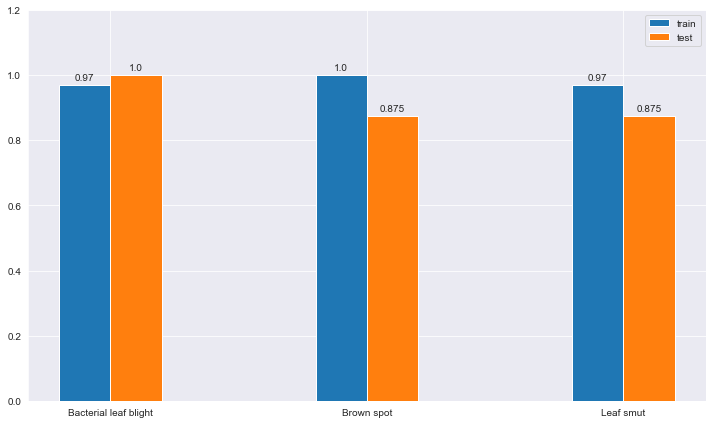

In [48]:
labels = ['Bacterial leaf blight', 'Brown spot', 'Leaf smut']
#recall
train = [0.97, 1, 0.97]
test = [1, 0.875, 0.875]

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(10,6))
rects1 = ax.bar(x - 0.1, train, width, label='train')
rects2 = ax.bar(x + 0.1, test, width, label='test')

# Add some text for labels, title and custom x-axis tick labels, etc.
#ax.set_ylabel('Percentage')
#ax.set_title('Classification Report on Recall each Class', fontdict={'fontsize':20})
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(0,1.2)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

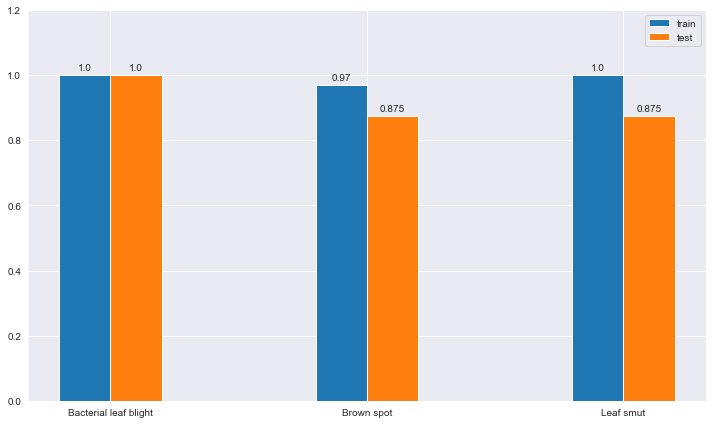

In [47]:
labels = ['Bacterial leaf blight', 'Brown spot', 'Leaf smut']

#precision
train = [1, 0.97, 1]
test = [1, 0.875, 0.875]


x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(10,6))
rects1 = ax.bar(x - 0.1, train, width, label='train')
rects2 = ax.bar(x + 0.1, test, width, label='test')

# Add some text for labels, title and custom x-axis tick labels, etc.
#ax.set_ylabel('Percentage')
#ax.set_title('Classification Report on Precision each Class', fontdict={'fontsize':20})
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(0,1.2)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

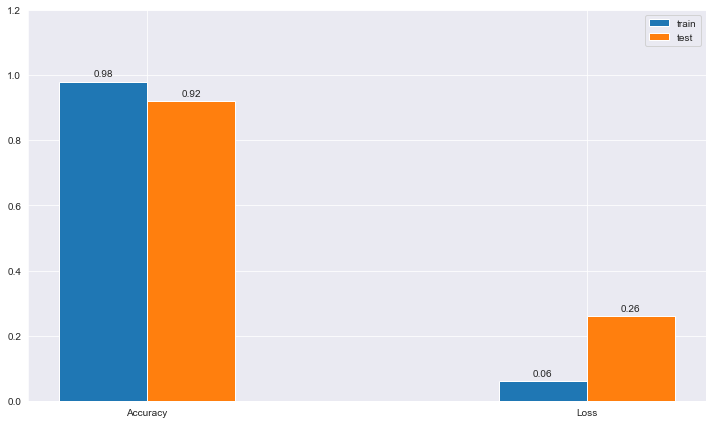

In [46]:
labels = ['Accuracy', 'Loss']

#acc
train = [0.98, 0.06] #0.9792
test = [0.92, 0.26] #0.9167

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(10,6))
rects1 = ax.bar(x - 0.1, train, width, label='train')
rects2 = ax.bar(x + 0.1, test, width, label='test')

# Add some text for labels, title and custom x-axis tick labels, etc.
#ax.set_ylabel('Percentage')
#ax.set_title('Accuracy and Loss', fontdict={'fontsize':20})
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(0,1.2)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

In [96]:
#Making Predictions and Verifying

preds = model.predict(val_ds,verbose=1)
pred = [np.argmax(i) for i in preds]
pred

4/4 [==============================] - 6s 1s/step


[0, 1, 2, 1, 1, 0, 2, 0, 0, 0, 0, 2, 1, 0, 2, 0, 1, 1, 1, 0, 0, 1, 1, 1]

In [95]:
pred = [np.argmax(i) for i in preds]
pred

[1, 1, 0, 2, 0, 1, 0, 1, 2, 2, 1, 1, 0, 0, 0, 1, 0, 2, 1, 1, 0, 0, 1, 0]

In [93]:
test_steps_per_epoch = np.math.ceil(val_ds.samples / val_ds.batch_size)
predictions = model.predict(val_ds, steps=test_steps_per_epoch)
# Get most likely class
predicted_classes = np.argmax(predictions, axis=1)
predicted_classes

array([2, 0, 0, 0, 2, 1, 0, 1, 0, 0, 2, 0, 2, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 0], dtype=int64)

In [83]:
val_ds.classes
class_labels = list(val_ds.class_indices.keys())

In [84]:
class_labels

['Bacterial leaf blight', 'Brown spot', 'Leaf smut']

In [86]:
actual = val_ds.classes

In [87]:
#Classification Report
print(classification_report(actual,pred))

              precision    recall  f1-score   support

           0       0.30      0.38      0.33         8
           1       0.40      0.50      0.44         8
           2       0.25      0.12      0.17         8

    accuracy                           0.33        24
   macro avg       0.32      0.33      0.31        24
weighted avg       0.32      0.33      0.31        24



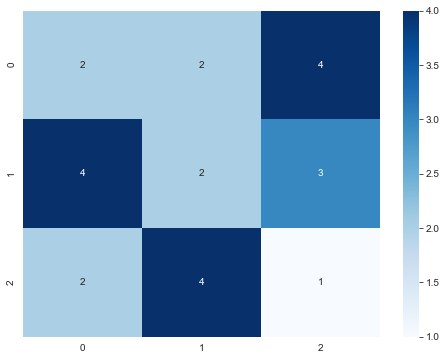

In [38]:
#Confusion Matrix
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(pred,actual),annot = True, fmt = 'd', cmap = 'Blues');

misal pake train

In [47]:
#test
model.evaluate(train_ds)

16/16 [==============================] - 28s 2s/step - loss: 0.1105 - accuracy: 0.9688


[0.11047574877738953, 0.96875]

In [50]:
#Making Predictions and Verifying

preds = model.predict(train_ds,verbose=1)

16/16 [==============================] - 26s 2s/step


In [51]:
pred = [np.argmax(i) for i in preds]
actual = train_ds.classes
#Classification Report
print(classification_report(actual,pred))

              precision    recall  f1-score   support

           0       0.41      0.41      0.41        32
           1       0.38      0.38      0.38        32
           2       0.41      0.41      0.41        32

    accuracy                           0.40        96
   macro avg       0.40      0.40      0.40        96
weighted avg       0.40      0.40      0.40        96



In [52]:
interp=ClassificationInterpretation.from_learner(model)
interp.plot_confusion_matrix(title='Confusion matrix')

NameError: name 'ClassificationInterpretation' is not defined

In [ ]:
#buat confusion matrix
#https://stackoverflow.com/questions/50825936/confusion-matrix-on-images-in-cnn-keras